# **Importing Libraries**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import pathlib

import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#for word embedding
import gensim
from gensim.models import Word2Vec

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# **Importing Dataset**

In [ ]:
#panggil dataset yang telah disimpan di Google Drive pribadi
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#explore the dataset
df = pd.read_excel('/content/drive/MyDrive/Pribadi/data_feedbacks.xlsx')
df

,label,ulasan
0,1.0,"Secara keseluruhan saya menyukai aplikasi ini,..."
1,1.0,Saya beri 4 bintang karena versi PC memiliki f...
2,0.0,1. Autoscroll ke bawah tidak dapat dinonaktifk...
3,1.0,Benar-benar waktu yang baik menggunakan aplika...
4,1.0,Ini adalah aplikasi yang bagus dan sangat muda...
...,...,...
189,1.0,Terima kasih telah memperhatikan pengguna Inte...
190,0.0,Performa yang sangat tidak dapat diandalkan un...
191,0.0,Dibandingkan dengan : hanya 2 bintang! Sangat...
192,0.0,"Setelah update terbaru, terus berpindah fold..."


1.0    97
0.0    97
Name: label, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


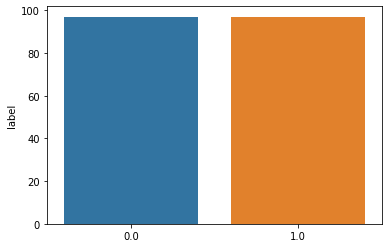

In [ ]:
x=df['label'].value_counts()
print(x)
sns.barplot(x.index,x)

In [ ]:
df.isna().sum()

label     0
ulasan    0
dtype: int64

In [ ]:
df['word_count'] = df['ulasan'].apply(lambda x: len(str(x).split()))
print(df[df['label']==1]['word_count'].mean()) #Positive feedbacks
print(df[df['label']==0]['word_count'].mean()) #Negative feedbacks

51.97938144329897
50.02061855670103


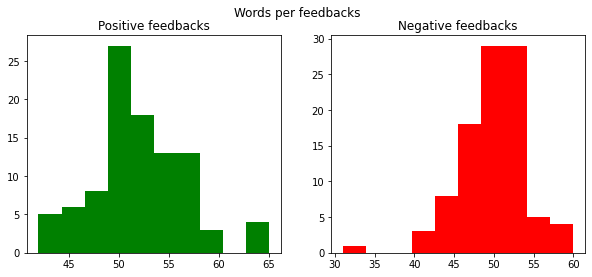

In [ ]:
# PLOTTING WORD-COUNT
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=df[df['label']==1]['word_count']
ax1.hist(train_words,color='green')
ax1.set_title('Positive feedbacks')
train_words=df[df['label']==0]['word_count']
ax2.hist(train_words,color='red')
ax2.set_title('Negative feedbacks')
fig.suptitle('Words per feedbacks')
plt.show()

In [ ]:
# CHARACTER-COUNT
df['char_count'] = df['ulasan'].apply(lambda x: len(str(x)))
print(df[df['label']==1]['char_count'].mean()) #Positive feedbacks
print(df[df['label']==0]['char_count'].mean()) #Negative feedbacks

355.3917525773196
351.54639175257734


# **Data Cleaning**

## **Preprocessing**

In [ ]:
#convert to lowercase, strip and remove punctuations
def preprocess(ulasan):
    ulasan = ulasan.lower() 
    ulasan = ulasan.strip()  
    ulasan = re.compile('<.*?>').sub('', ulasan) 
    ulasan = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', ulasan)  
    ulasan = re.sub('\s+', ' ', ulasan)  
    ulasan = re.sub(r'\[[0-9]*\]',' ',ulasan) 
    ulasan = re.sub(r'[^\w\s]', '', str(ulasan).lower().strip())
    ulasan = re.sub(r'\d',' ',ulasan) 
    ulasan = re.sub(r'\s+',' ',ulasan) 
    return ulasan

In [ ]:
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

In [ ]:
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

# **Final Preprocessing**

In [ ]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

In [ ]:
df['clean_text'] = df['ulasan'].apply(lambda x: finalpreprocess(x))
df.head()

,label,ulasan,word_count,char_count,clean_text
0,1.0,"Secara keseluruhan saya menyukai aplikasi ini,...",53,385,secara keseluruhan saya menyukai aplikasi ini ...
1,1.0,Saya beri 4 bintang karena versi PC memiliki f...,50,319,saya beri bintang karena versi pc memiliki fit...
2,0.0,1. Autoscroll ke bawah tidak dapat dinonaktifk...,48,325,autoscroll ke bawah tidak dapat dinonaktifkan ...
3,1.0,Benar-benar waktu yang baik menggunakan aplika...,56,378,benar benar waktu yang baik menggunakan aplika...
4,1.0,Ini adalah aplikasi yang bagus dan sangat muda...,64,407,ini adalah aplikasi yang bagus dan sangat muda...


In [ ]:
X=df['ulasan'].values

In [ ]:
Y=df['label'].values

In [ ]:
#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,shuffle=True)

# **Count Vectorizer**

In [ ]:
vec = CountVectorizer()

In [ ]:
vec.fit(X_train)

CountVectorizer()

In [ ]:
x_train=vec.transform(X_train)

In [ ]:
x_test=vec.transform(X_test)

In [ ]:
x_train

<155x1284 sparse matrix of type '<class 'numpy.int64'>'
	with 6259 stored elements in Compressed Sparse Row format>

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
model = Sequential()
model.add(Dense(16, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 16)                20560     
                                                                 
 dense_7 (Dense)             (None, 16)                272       
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 20,849
Trainable params: 20,849
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(x_train, Y_train,epochs=100,verbose=True,batch_size=16)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_2/dense_6/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_2/dense_6/embedding_lookup_sparse/Reshape:0", shape=(None, 16), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_2/dense_6/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


10/10 [==============================] - 1s 2ms/step - loss: 0.6876 - accuracy: 0.5355
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 0.6336 - accuracy: 0.7484
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 0.5850 - accuracy: 0.8516
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 0.5266 - accuracy: 0.9355
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 0.4595 - accuracy: 0.9613
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 0.3884 - accuracy: 0.9742
Epoch 7/100
10/10 [==============================] - 0s 3ms/step - loss: 0.3158 - accuracy: 0.9806
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 0.2499 - accuracy: 0.9806
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 0.1902 - accuracy: 0.9935
Epoch 10/100
10/10 [==============================] - 0s 4ms/step - loss: 0.1442 - accuracy: 0.9935
Epoch 11/100
10/10 [=

In [ ]:
model.evaluate(x_train,Y_train)

5/5 [==============================] - 0s 3ms/step - loss: 2.3790e-04 - accuracy: 1.0000


[0.0002378965145908296, 1.0]

In [ ]:
model.evaluate(x_test,Y_test)

2/2 [==============================] - 0s 4ms/step - loss: 0.5360 - accuracy: 0.8205


[0.536030113697052, 0.8205128312110901]

In [ ]:
#Done

# **TF-IDF Vectorizer**

In [ ]:
vec = TfidfVectorizer()

In [ ]:
vec.fit(X_train)

TfidfVectorizer()

In [ ]:
x_train=vec.transform(X_train)
x_test=vec.transform(X_test)

In [ ]:
x_train

<155x1284 sparse matrix of type '<class 'numpy.float64'>'
	with 6259 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(x_train, Y_train)

LogisticRegression()

In [ ]:
score_test = lr.score(x_test, Y_test)

In [ ]:
score_test

0.7692307692307693

In [ ]:
score_train = lr.score(x_train, Y_train)

In [ ]:
score_train

0.9612903225806452

In [ ]:
#Done

# **Building Model**

In [ ]:
export_dir = '/content/drive/MyDrive/Pribadi/saved/model'
tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Pribadi/saved/model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Pribadi/saved/model/assets


# **Convert the SavedModel to TFLite**

In [ ]:
#convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [ ]:
tflite_model_file = pathlib.Path('/content/drive/MyDrive/Pribadi/model.tflite')
tflite_model_file.write_bytes(tflite_model)

85232